In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

import random
import time
from collections import defaultdict

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [146]:
class Network(nn.Module):
    
    def __init__(self, len_states, len_actions, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(len_states, num_hidden)
        self.l2 = nn.Linear(num_hidden, len_actions)

    def forward(self, x):
        # YOUR CODE HERE
        z1 = self.l1(x)
        a1 = F.relu(z1)
        z2 = self.l2(a1)
        a2 = torch.nn.functional.log_softmax(z2)
        
        return a2

In [69]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1234)
model = PolicyNetwork(4, 2, num_hidden)

x = torch.rand(10, 4)

log_p = model(x)

# Does the outcome make sense?
print(log_p.exp())


tensor([[0.4578, 0.5422],
        [0.4657, 0.5343],
        [0.4563, 0.5437],
        [0.4634, 0.5366],
        [0.4564, 0.5436],
        [0.4725, 0.5275],
        [0.4769, 0.5231],
        [0.4834, 0.5166],
        [0.4797, 0.5203],
        [0.4618, 0.5382]], grad_fn=<ExpBackward>)


/home/raymond/anaconda3/envs/rl2019/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


In [104]:
def select_action(model, state):
    # Samples an action according to the probability distribution induced by the model
    # Also returns the log_probability
    # YOUR CODE HERE
    state = torch.tensor(state, dtype=torch.float)
    log_p = model(state)
    action = torch.multinomial(log_p.exp(), 1).item()
    return action, log_p[action]

def run_episode(env, model):
    # YOUR CODE HERE
    s = env.reset()
    done = False
    episode = []
    while not done:
        a, log_p = select_action(model, s)
        #print(s)
        s_next, r, done, _ = env.step(a)
        episode.append((r, log_p))
        s = s_next

    return episode

def compute_reinforce_loss(episode, discount_factor):
    # Compute the reinforce loss
    # Make sure that your function runs in LINEAR TIME
    # Don't forget to normalize your RETURNS (not rewards)
    # Note that the rewards/returns should be maximized 
    # while the loss should be minimized so you need a - somewhere
    
    # YOUR CODE HERE
    G_list = []
    log_p_list = []
    G = 0
    for r, log_p in reversed(episode):
        log_p_list.append(log_p)
        G = discount_factor * G + r
        G_list.append(G)
        
    log_p_vector = torch.stack(log_p_list)
    
    G_vector = torch.tensor(G_list, dtype=torch.float)
    mean = torch.mean(G_vector)
    std = torch.std(G_vector)
    G_norm = (G_vector - mean)/std
    
    loss = -log_p_vector @ G_norm
    return loss


def run_episodes_policy_gradient(model, env, num_episodes, discount_factor, learn_rate):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    episode_durations = []
    for i in range(num_episodes):
        
        # YOUR CODE HERE
        episode = run_episode(env, model)
        loss = compute_reinforce_loss(episode, discount_factor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                           
        if i % 10 == 0:
#             print("{2} Episode {0} finished after {1} steps"
#                   .format(i, len(episode), '\033[92m' if len(episode) >= 195 else '\033[99m'))
            print(len(episode))
        episode_durations.append(len(episode))
        
    return episode_durations

In [137]:
import gym
#env = gym.envs.make("CartPole-v0")
#env = gym.envs.make("MountainCar-v0")
env = gym.envs.make("Acrobot-v1")
#env = gym.envs.make("Pendulum-v0")

print(env.action_space.n)
print(env.observation_space.shape[0])

a = env.action_space.n
s = env.observation_space.shape[0]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
3
6


In [96]:
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

/home/raymond/anaconda3/envs/rl2019/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


500
500
500
500
232
265
281
355
319
186


Text(0, 0.5, 'Episode length')

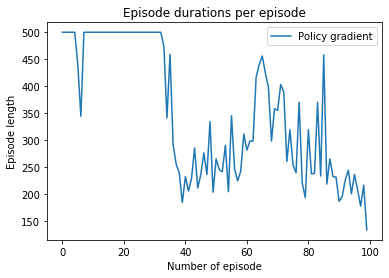

In [147]:
# Feel free to play around with the parameters!
num_episodes = 100
discount_factor = 0.99
learn_rate = 0.01
seed = 42
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

model = Network(s, a, num_hidden)

episode_durations_policy_gradient = run_episodes_policy_gradient(
    model, env, num_episodes, discount_factor, learn_rate)

plt.plot(episode_durations_policy_gradient)
plt.title('Episode durations per episode')
plt.legend(['Policy gradient'])
plt.xlabel("Number of episode")
plt.ylabel("Episode length")